## Predicting churn for a gym using machine learning

The gym chain Model Fitness is developing a customer interaction strategy based on analytical data. One of the most common problems gyms and other services face is customer churn. How do you know if a customer is no longer with you? You can calculate churn based on people who get rid of their accounts or don't renew their contracts. However, sometimes it's not obvious that a client has left: they may walk out on tiptoes.

Churn indicators vary from field to field. If a user buys from an online store rarely but regularly, you can't say they're a runaway. But if for two weeks they haven't opened a channel that's updated daily, that's a reason to worry: your follower might have gotten bored and left you.

For a gym, it makes sense to say a customer has left if they don't come for a month. Of course, it's possible they're in Cancun and will resume their visits when they return, but's that's not a typical case. Usually, if a customer joins, comes a few times, then disappears, they're unlikely to come back.

In order to fight churn, Model Fitness has digitized a number of its customer profiles. My task is to analyze them and come up with a customer retention strategy. In this project, I will:
 - Learn to predict the probability of churn (for the upcoming month) for each customer
 - Draw up typical user portraits: select the most outstanding groups and describe their main feature
 - Analyze the factors that impact churn most
 - Draw basic conclusions and develop recommendations on how to improve customer service
      - Identify target groups
      - Suggest measures to cut churn
      - Describe any other patterns you see with respect to interaction with customers

### Description of the data

Model Fitness provided me with CSV files containing data on churn for a given month and information on the month preceding it. The dataset includes the following fields:
 - **'Churn'** — the fact of churn for the month in question
 - Current dataset fields:
     - User data for the preceding month
         - **'gender'**
         - **'Near_Location'** — whether the user lives or works in the neighborhood where the gym is located
         - **'Partner'** — whether the user is an employee of a partner company (the gym has partner companies whose employees get discounts; in those cases the gym stores information on customers' employers)
         - **Promo_friends** — whether the user originally signed up through a "bring a friend" offer (they used a friend's promo code when paying for their first membership)
         - **'Phone'** — whether the user provided their phone number
         - **'Age'**
         - **'Lifetime'** — the time (in months) since the customer first came to the gym
     - Data from the log of visits and purchases and data on current membership status
         - **'Contract_period'** — 1 month, 3 months, 6 months, or 1 year
         - **'Month_to_end_contract'** — the months remaining until the contract expires
         - **'Group_visits'** — whether the user takes part in group sessions
         - **'Avg_class_frequency_total'** — average frequency of visits per week over the customer's lifetime
         - **'Avg_class_frequency_current_month'** — average frequency of visits per week over the preceding month
         - **'Avg_additional_charges_total'** — the total amount of money spent on other gym services: cafe, athletic goods, cosmetics, massages, etc.

### Step 1: Open data file & look at general info <a name="step_1"></a>

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
# try-except block handles errors that occur from changing file directories

try:
    data = pd.read_csv('gym_churn_us.csv')
except:
    data = pd.read_csv('/datasets/gym_churn_us.csv')

In [3]:
# print head, general info, descriptive stats

display(data.head())
display(data.info())
display(data.describe())

gender  Near_Location  Partner  Promo_friends  Phone  Contract_period  \
0       1              1        1              1      0                6   
1       0              1        0              0      1               12   
2       0              1        1              0      1                1   
3       0              1        1              1      1               12   
4       1              1        1              1      1                1   

   Group_visits  Age  Avg_additional_charges_total  Month_to_end_contract  \
0             1   29                     14.227470                    5.0   
1             1   31                    113.202938                   12.0   
2             0   28                    129.448479                    1.0   
3             1   33                     62.669863                   12.0   
4             0   26                    198.362265                    1.0   

   Lifetime  Avg_class_frequency_total  Avg_class_frequency_current_month  \
0         3                   0.020398                           0.000000   
1         7                   1.922936                           1.910244   
2         2                   1.859098                           1.736502   
3         2                   3.205633                           3.357215   
4         3                   1.113884                           1.120078   

   Churn  
0      0  
1      0  
2      0  
3      0  
4      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

gender  Near_Location      Partner  Promo_friends        Phone  \
count  4000.000000    4000.000000  4000.000000    4000.000000  4000.000000   
mean      0.510250       0.845250     0.486750       0.308500     0.903500   
std       0.499957       0.361711     0.499887       0.461932     0.295313   
min       0.000000       0.000000     0.000000       0.000000     0.000000   
25%       0.000000       1.000000     0.000000       0.000000     1.000000   
50%       1.000000       1.000000     0.000000       0.000000     1.000000   
75%       1.000000       1.000000     1.000000       1.000000     1.000000   
max       1.000000       1.000000     1.000000       1.000000     1.000000   

       Contract_period  Group_visits          Age  \
count      4000.000000   4000.000000  4000.000000   
mean          4.681250      0.412250    29.184250   
std           4.549706      0.492301     3.258367   
min           1.000000      0.000000    18.000000   
25%           1.000000      0.000000    27.000000   
50%           1.000000      0.000000    29.000000   
75%           6.000000      1.000000    31.000000   
max          12.000000      1.000000    41.000000   

       Avg_additional_charges_total  Month_to_end_contract     Lifetime  \
count                   4000.000000            4000.000000  4000.000000   
mean                     146.943728               4.322750     3.724750   
std                       96.355602               4.191297     3.749267   
min                        0.148205               1.000000     0.000000   
25%                       68.868830               1.000000     1.000000   
50%                      136.220159               1.000000     3.000000   
75%                      210.949625               6.000000     5.000000   
max                      552.590740              12.000000    31.000000   

       Avg_class_frequency_total  Avg_class_frequency_current_month  \
count                4000.000000                        4000.000000   
mean                    1.879020                           1.767052   
std                     0.972245                           1.052906   
min                     0.000000                           0.000000   
25%                     1.180875                           0.963003   
50%                     1.832768                           1.719574   
75%                     2.536078                           2.510336   
max                     6.023668                           6.146783   

             Churn  
count  4000.000000  
mean      0.265250  
std       0.441521  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000

### Step 2: Exploratory data analysis

There are no missing values in the imported data, so we don't need to take any further action in that aspect. Looking at some of the descriptive statistics, we can see roughly 27% of the people result in churns. The average age is 29, and there are roughly the same number of men and women in the data set. 85% of the people live near the gym, and 90% provided their phone number. The average contract period is a little over 4 and a half months.

#### Mean feature values for churn & non-churn

In [4]:
# group features by churn

data.groupby('Churn').mean()

gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.027882  
1                               1.044546

#### Feature distribution plots for churners & non-churners

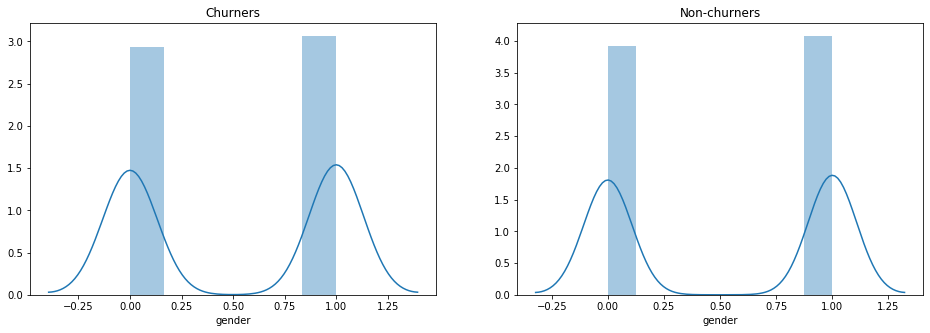

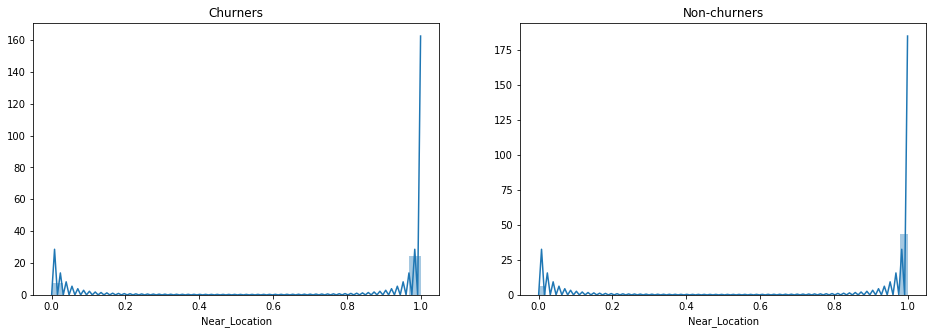

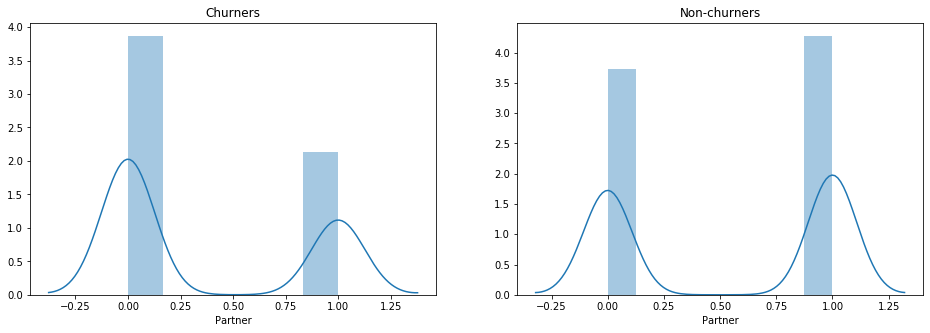

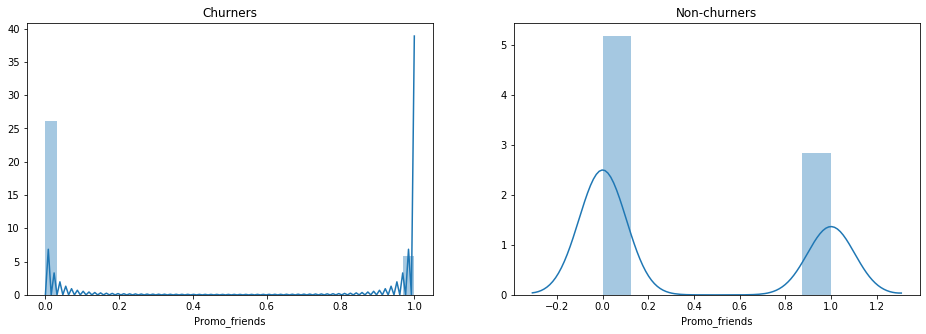

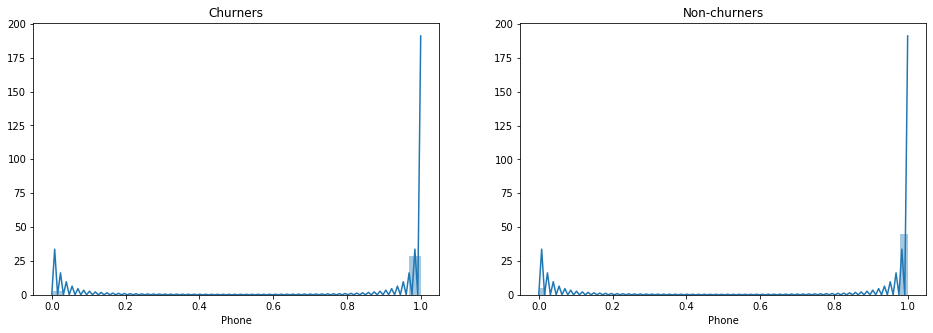

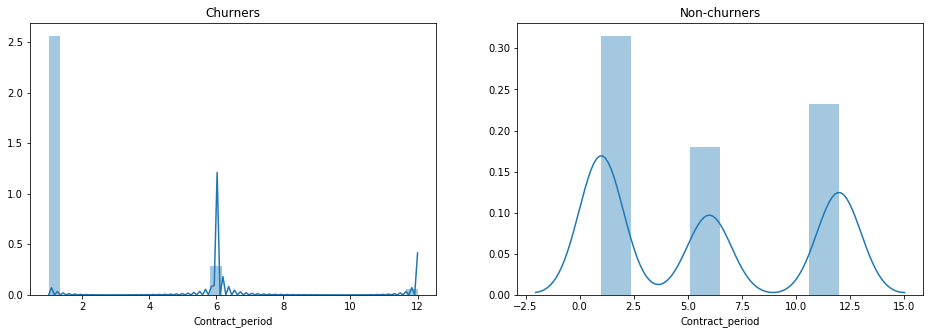

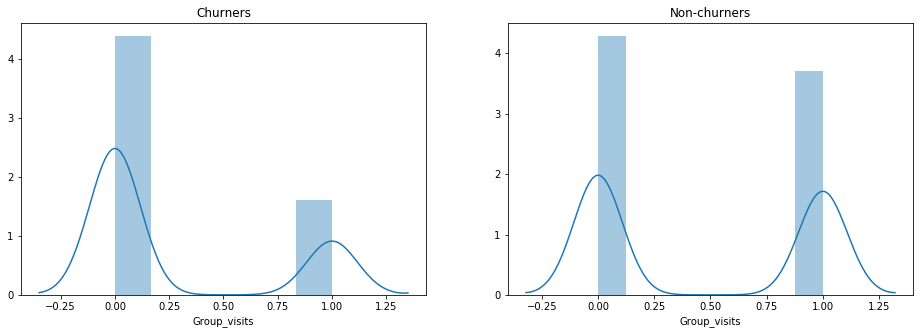

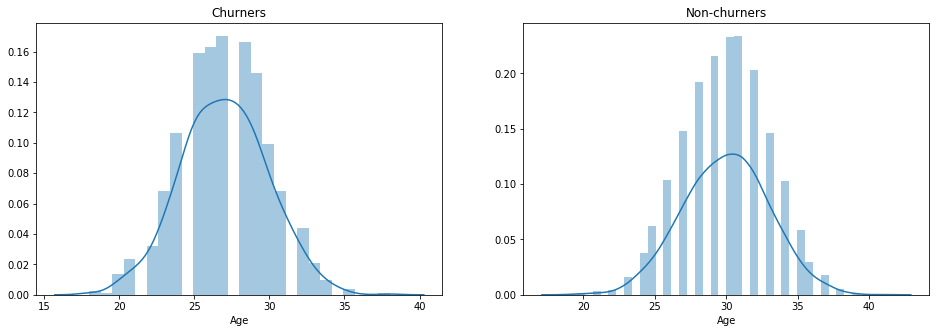

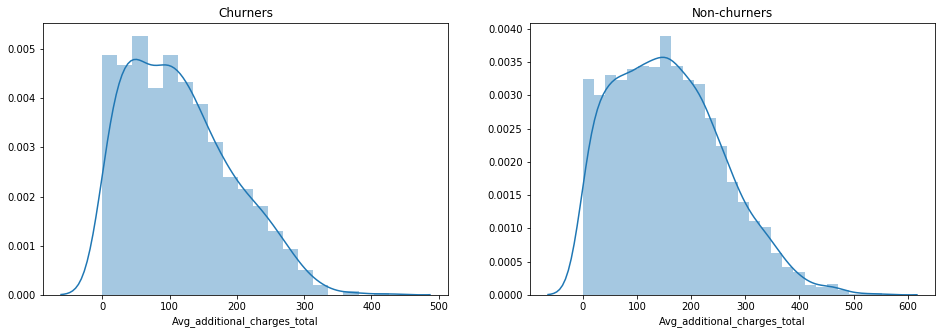

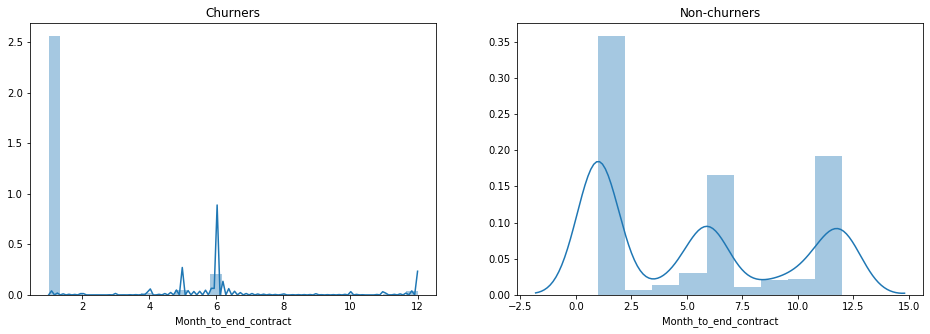

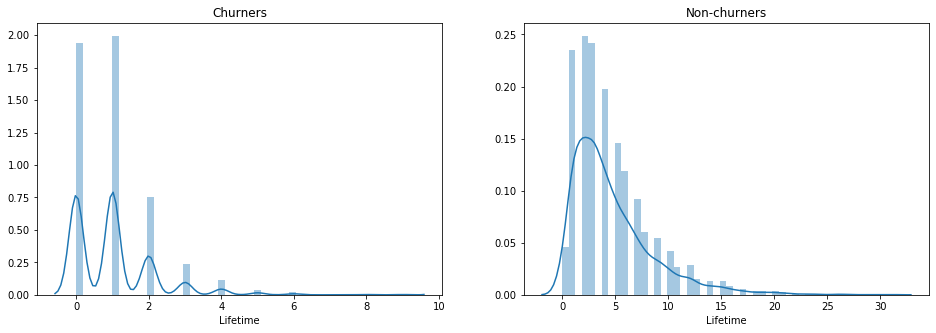

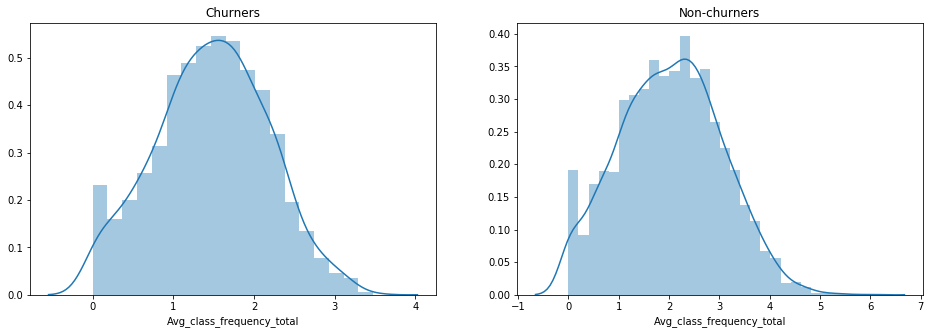

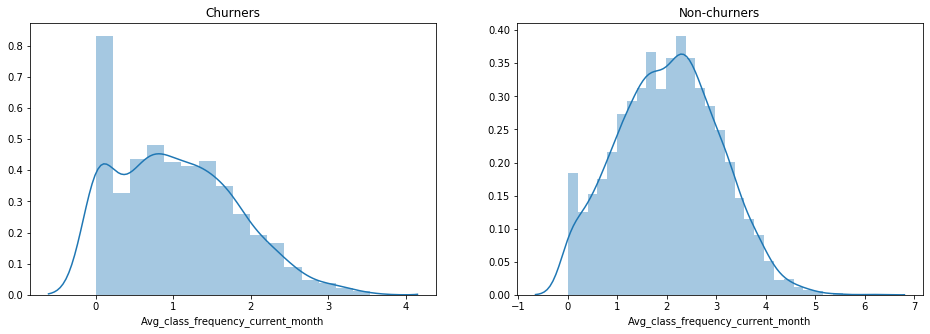

In [5]:
# plotting distrubutions for each feature using Seaborn

churners = data.query('Churn == 1').drop('Churn', axis=1)
non_churners = data.query('Churn == 0').drop('Churn', axis=1)

for col in churners.columns:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    axes = axes.reshape(-1)
    
    axes[0].set_title('Churners')
    axes[1].set_title('Non-churners')
    
    sns.distplot(churners[col], ax=axes[0], hist_kws={'density': True}, fit=None)
    sns.distplot(non_churners[col], ax=axes[1], hist_kws={'density': True}, fit=None)

##### Conclusions
- Non-churners are more likely to be an employee of a partner company than churners
- Non-churners are also more likely to originally have signed up through a "bring a friend" offer
- Churners on average have a smaller contract period than non-churners
- Non-churners are more likely to take part in group sessions
- Non-churners have a greater lifetime (the time since the customer first came to the gym)
- Non-churners take part in classes more often
- Features like gender, age, whether or not a phone number was given during sign-up, and location do not vary much between groups

#### Correlation matrix for features

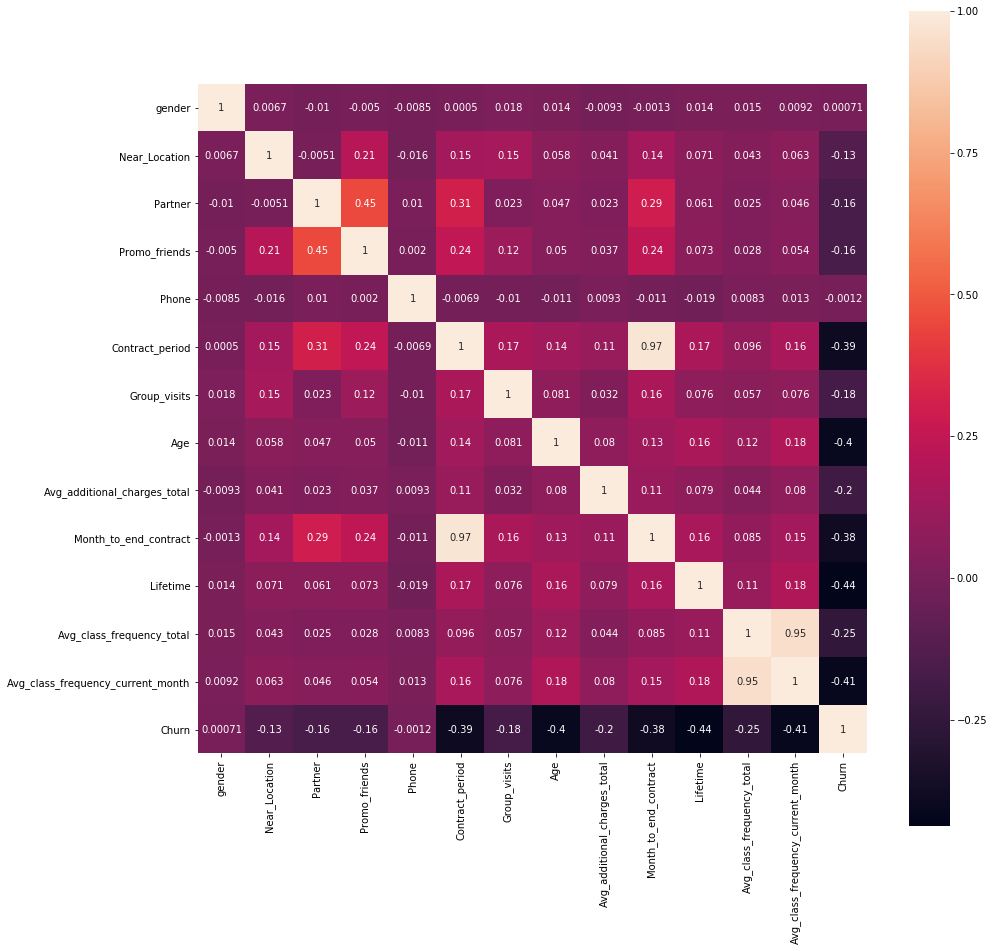

In [6]:
# plot heatmap of correlation matrix

fig = plt.figure(figsize=(15, 15))

cm = data.corr()

sns.heatmap(cm, annot=True, square=True)
plt.show()

##### Conclusion
Contract period, age, additional charges, proximity in time the the end of the contract, customer liftime, and class frequency are all negatively correlated with churn rate.

The contract period and proximity to the end of the contract are two features that are highly correlated. The average class frequency of the current month and the average class frequency in total are also two highly correlated features. We may need to address these to avoid multicollinearity.

### Step 3: Build a model to predict user churn

Next, we'll build a binary classification model for customers where the target feature is whether or not the user will leave next month. We'll divide the data in train and validation sets and train two models using Logistic Regression and Random Forest algortithms. Then we'll evaluate accuracy, precision, and recall for both models with the validation set, 

#### Data preprocessing

In [7]:
# divide data into train & validations sets

X = data.drop('Churn', axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
# standardize data

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)

In [9]:
# apply standardizer to validation set

X_test_st = scaler.transform(X_test)

In [10]:
# show resulting arrays

display(X_train_st[:2], X_test_st[:2])

array([[-1.02724604,  0.42316838,  1.02467945,  1.50398723,  0.33966338,
         1.61618334,  1.19418607,  1.49211656,  0.38640884,  0.64978725,
         0.33267126, -0.84666805, -0.74735039],
       [ 0.97347662,  0.42316838,  1.02467945, -0.66489926,  0.33966338,
        -0.8064055 , -0.83739044, -0.67247193, -1.10861304, -0.78985217,
        -0.196034  ,  0.22688385,  0.4103166 ]])

array([[-1.02724604,  0.42316838,  1.02467945, -0.66489926,  0.33966338,
        -0.8064055 , -0.83739044,  1.49211656, -1.04443977, -0.78985217,
        -0.98909188, -0.90448435, -1.69338907],
       [ 0.97347662,  0.42316838, -0.97591496, -0.66489926,  0.33966338,
        -0.8064055 , -0.83739044, -0.67247193, -1.27210574, -0.78985217,
         0.06831863, -0.51259687, -0.76024453]])

#### Training models with binary classification algorithms

In [11]:
# list of models

models = [LogisticRegression(random_state=1), RandomForestClassifier(random_state=1)]

In [12]:
# function trains model  & prints metrics

def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)
    
    print(m, '\n    Accuracy: {:.2f}\n    Precision: {:.2f}\n    Recall: {:.2f}\n'.format(results[0], results[1], results[2]))

In [13]:
# loop through models list & print metrics

for model in models:
    make_prediction(model, X_train_st, y_train, X_test_st, y_test)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False) 
    Accuracy: 0.93
    Precision: 0.88
    Recall: 0.86

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False) 
    Accuracy: 0.92
    Precision: 0.90
    Recall: 0.79



##### Conclusions
The Logistic Regression algorithm had slightly better performance on all 3 metrics. We should use this one when trying to predict actual future churn for gym members.

### Step 4: Create user clusters

Next, we'll train a clustering model to identify different user groups. We need to standardize the data, plot a dendrogram, train the model, and plot distributions of features for clusters. Then we can calulate churn rate for each cluster and form conclusions.

#### Create dendrogram

In [14]:
# standardize data

X_sc = scaler.fit_transform(data.drop('Churn', axis=1))

In [15]:
# build distance matrix & dendrogram

fig = ff.create_dendrogram(X_sc)
fig.update_layout(width=800, height=500)
fig.show()

#### Train KMeans model & group features by clusters

In [16]:
# define the k_means model with 5 clusters & predict clusters

km = KMeans(n_clusters=5, random_state=1)
labels = km.fit_predict(X_sc)

In [17]:
# store cluster labels in the field of our dataset

data['cluster_km'] = labels

In [18]:
# get the statistics of the mean feature values per cluster

data.groupby('cluster_km').mean().sort_values(by='Churn')

gender  Near_Location   Partner  Promo_friends  Phone  \
cluster_km                                                            
2           0.498371       0.951140  0.739414       0.466884    1.0   
3           0.505426       1.000000  0.773643       1.000000    1.0   
4           0.523316       0.862694  0.471503       0.305699    0.0   
1           0.519319       1.000000  0.224623       0.000000    1.0   
0           0.500960       0.000000  0.464491       0.078695    1.0   

            Contract_period  Group_visits        Age  \
cluster_km                                             
2                 11.511401      0.543974  29.964169   
3                  2.972093      0.451163  29.120930   
4                  4.777202      0.427461  29.297927   
1                  2.056974      0.379175  28.918140   
0                  2.343570      0.216891  28.579655   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km                                                                  
2                             166.325823              10.457112  4.829533   
3                             141.317434               2.778295  3.662016   
4                             144.208179               4.466321  3.940415   
1                             141.863877               1.963982  3.309758   
0                             136.561586               2.197697  2.905950   

            Avg_class_frequency_total  Avg_class_frequency_current_month  \
cluster_km                                                                 
2                            2.116481                           2.109532   
3                            1.834968                           1.731981   
4                            1.854211                           1.723967   
1                            1.808608                           1.655857   
0                            1.738534                           1.562870   

               Churn  
cluster_km            
2           0.019544  
3           0.252713  
4           0.266839  
1           0.362148  
0           0.429942

##### Conclusion
Those clusters with the highest churn rates have lower average class frequencies, lower lifetimes, a short time until the end of their contract, shorter contract periods, and less referals from friends. This is in line with our initial exploratory data. It's probably safe to say that this model is an accurate.

#### Distributions of features for each cluster

In [19]:
# separate DataFrames for each cluster

cluster_0 = data.query('cluster_km == 0').drop('cluster_km', axis=1)
cluster_1 = data.query('cluster_km == 1').drop('cluster_km', axis=1)
cluster_2 = data.query('cluster_km == 2').drop('cluster_km', axis=1)
cluster_3 = data.query('cluster_km == 3').drop('cluster_km', axis=1)
cluster_4 = data.query('cluster_km == 4').drop('cluster_km', axis=1)

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



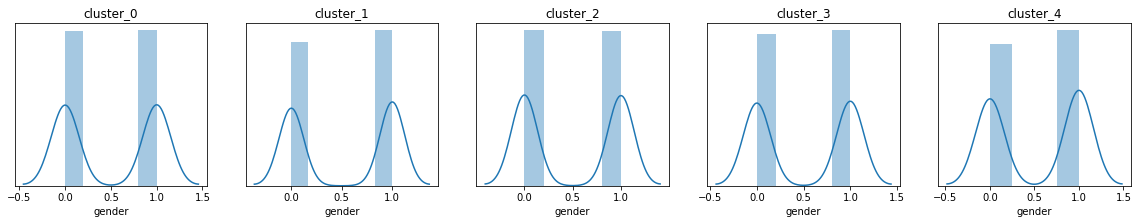

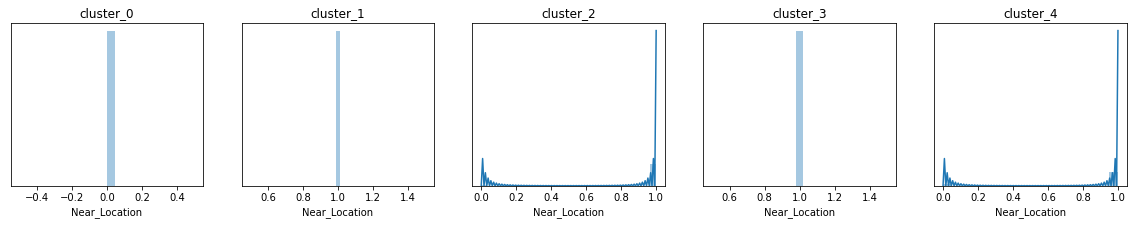

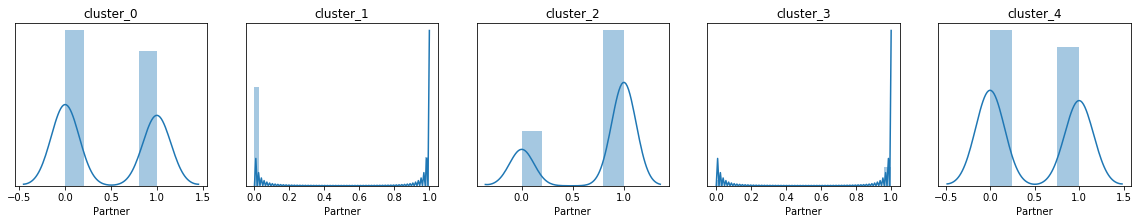

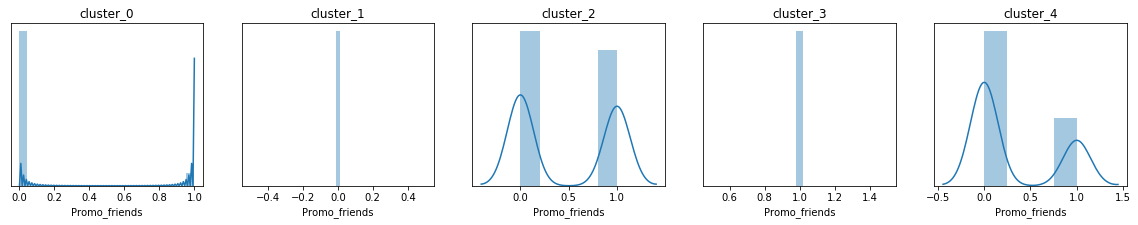

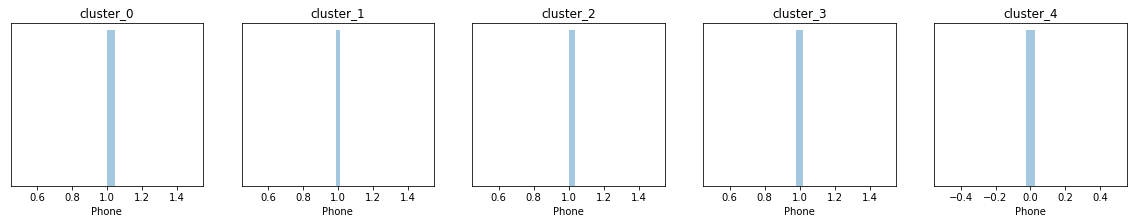

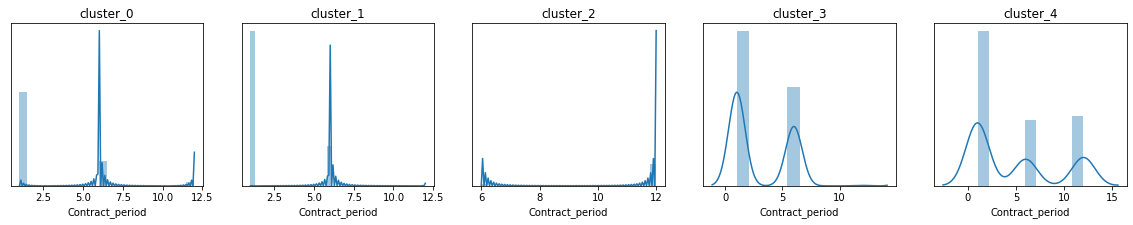

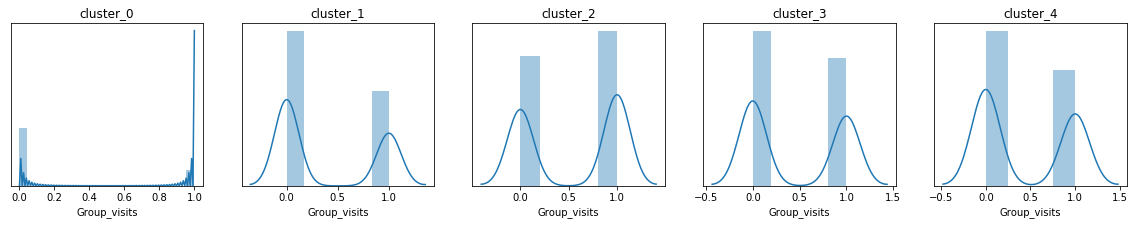

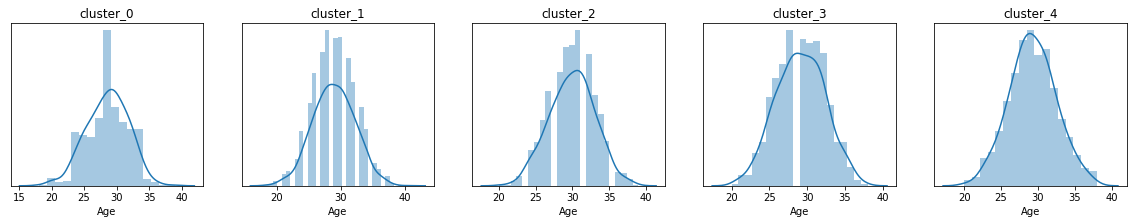

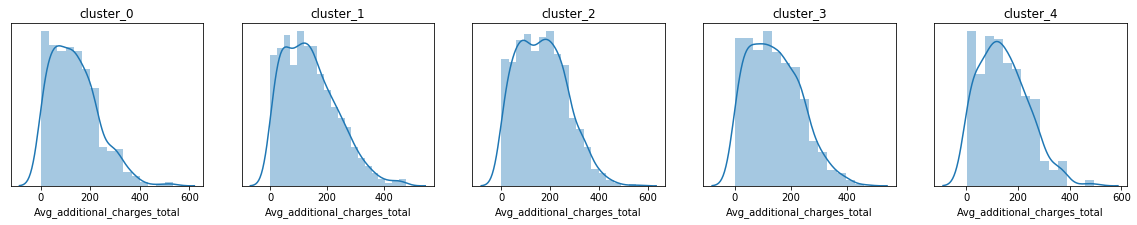

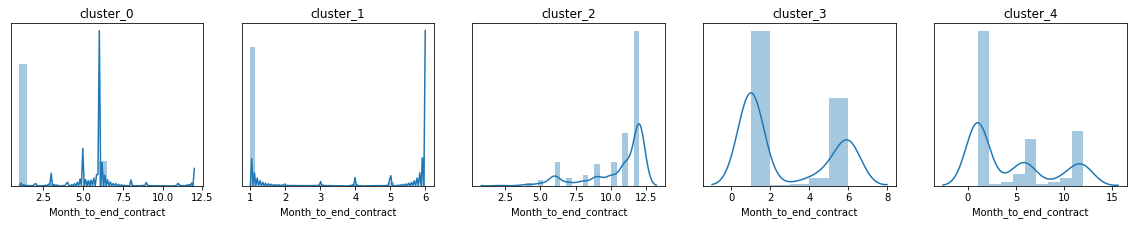

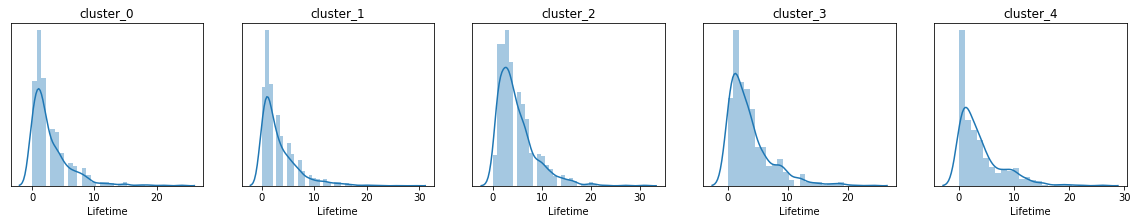

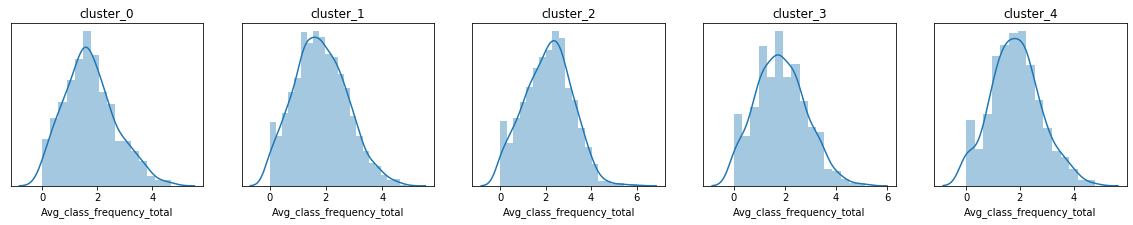

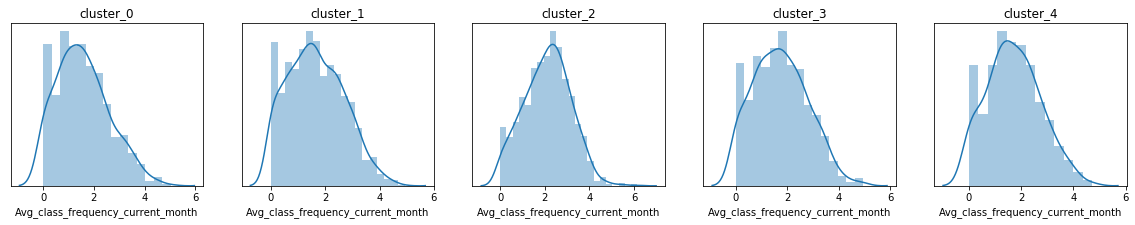

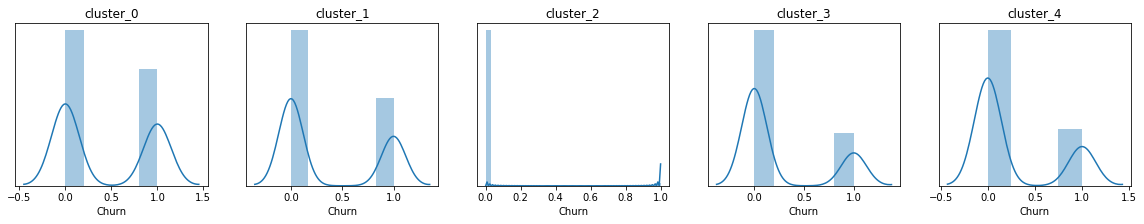

In [20]:
# plotting distributions of features for all 5 clusters

for col in cluster_0.columns:
    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    axes = axes.reshape(-1)
    
    for i in range(5):
        axes[i].set_title('cluster_' + str(i))
        axes[i].get_yaxis().set_visible(False)
    
    sns.distplot(cluster_0[col], ax=axes[0], hist_kws={'density': True}, fit=None)
    sns.distplot(cluster_1[col], ax=axes[1], hist_kws={'density': True}, fit=None)
    sns.distplot(cluster_2[col], ax=axes[2], hist_kws={'density': True}, fit=None)
    sns.distplot(cluster_3[col], ax=axes[3], hist_kws={'density': True}, fit=None)
    sns.distplot(cluster_4[col], ax=axes[4], hist_kws={'density': True}, fit=None)

##### Conclusions

 - Cluster 3 had no guests who lived close to the gym, while the others had nearly all guests living close to the gym.
 - Age and additional charges distributions for all 5 clusters were the same
 - Class frequencies for clusters 1 & 2 were normally distributed with no skew, while the remaining showed a right-skew distribion pattern
 - Lifetimes for clusters 0, 1, & 2 were considerably less
 - Churn for clusters 0, 1 & 2 were considerably higher

### Step 5: General conclusion & recommendations

After our exploratory analysis and machine learning analysis, we can come to the following conclusions about gym customers and what features make them more likely to churn:

- Gender, phone number collection, and age don't make a difference
- Proximity to the gym makes customers less likely to churn
- Longer lifetimes and contract lengths lead to less churn
- Higher class participation frequencies lead to less churn
- People nearing the end of their contract also churn more often since their contract is up soon anyway
- People who do group sessions are less likely to churn

We should focus on building new gym locations closer to peoples homes, so it's more convenient for them to get to the gym. This will reduce churn rate. We should also focus on pushing people to attend group sessions, and renewing their contracts for longer periods before they expire. Maybe instead of offering a 1 month minimum, we could offer 3 month minimum contract, sinc those with 1 month are less invested financially and therefore are more likely to churn.